In [1]:
import requests
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import yfinance as yf

from pandas_datareader import data as pdr
yf.pdr_override()
import bisect

import math
from scipy.stats import gaussian_kde
from scipy.integrate import quad

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/tmp/ipykernel_1034068/3626073774.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
url = 'http://127.0.0.1:25510/v2/list/roots/option'
headers = {'Accept': 'application/json'}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    # The request was successful
    json_data = response.json()
    print(json_data)
else:
    # Request failed
    print(f"Request failed with status code {response.status_code}")
    print(response.text)

{'header': {'latency_ms': 75, 'format': ['root']}, 'response': ['1BXSL', '1INVH', '1LNCO', '1LUV', '2CLSK', '2LW', '9AC', '9AD', '9AE', '9BC', '9BD', '9BE', '9CC', '9CD', '9CE', '9DC', '9DD', '9DE', '9EC', '9ED', '9EE', '9FC', '9FD', '9FE', '9GC', '9GD', '9GE', '9HC', '9HD', '9HE', '9IC', '9ID', '9IE', '9JC', '9JD', '9JE', '9KC', '9KD', '9KE', '9LC', '9LD', '9LE', '9MC', '9MD', '9ME', '9NC', '9ND', '9NE', '9OC', '9OD', '9OE', '9PC', '9PD', '9PE', '9QC', '9QD', '9QE', '9RC', '9RD', '9RE', '9SC', '9SD', '9SE', '9TC', '9TD', '9TE', '9UC', '9UD', '9UE', '9VC', '9VD', '9VE', '9WC', '9WD', '9WE', '9XC', '9XD', '9XE', '9YC', '9YD', '9YE', 'A', 'A1', 'AA', 'AA1', 'AAAP', 'AABA', 'AABA1', 'AAC', 'AACC', 'AACH', 'AACQ', 'AAD', 'AADI', 'AAE', 'AAGR1', 'AAIC', 'AAL', 'AAL1', 'AAL2', 'AAMRQ', 'AAN', 'AAOI', 'AAON', 'AAON1', 'AAP', 'AAPB', 'AAPD', 'AAPL', 'AAPL7', 'AAPU', 'AAPX', 'AAT', 'AAU', 'AAU1', 'AAV', 'AAVL', 'AAVVF', 'AAWW', 'AAXJ', 'AAXN', 'AB', 'ABAT', 'ABAX', 'ABB', 'ABB1', 'ABBNY', 'ABBV

In [3]:
from enum import Enum

class Security(Enum):
    OPTION = 'option'
    EQUITY = 'stock'
    
class Req(Enum):
    TRADE = 'trade'
    QUOTE = 'quote'
    OI = 'open_interest'

class Right(Enum):
    CALL = 'C'
    PUT = 'P'

In [4]:
class ThetaDataAPI:
    def __init__(self):
        self.base_url = 'http://127.0.0.1:25510/v2/'

    def _get_req(self, url: str, headers: dict, params: dict=None):
        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Request failed with status code {response.status_code}")
            print(response.text)

    def get_roots(self, security_type: Security=Security.OPTION):
        url = f'{self.base_url}list/roots?sec={security_type.value}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)

    def get_expirations(self, root:str):
        url = f'{self.base_url}list/expirations?root={root}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_strikes(self, root: str, exp: str):
        url = f'{self.base_url}list/strikes?root={root}&exp={exp}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_dates(self, root: str, security_type: Security=Security.OPTION, exp: str=None, strike_right: tuple[str, Right]=None):
        url = f'{self.base_url}list/dates/{security_type.value}/quote'
        url_params = {}
        url_params["root"] = root
        if exp is not None:
            url_params["exp"] = exp
        if strike_right is not None:
            url_params["strike"] = strike_right[0]
            url_params["right"] = strike_right[1].value
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers, params=url_params)
    
    """
    NOTE this function has a 750ms overhead 
    """
    def get_contracts(self, date: str, req: Req=Req.TRADE):
        url = f'{self.base_url}list/contracts/option/{req.value}?start_date={date}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
        
    def get_eod_prices(self, root: str, security_type: Security, start_date: str, end_date: str, exp: str=None, strike: str=None, right: Right=None):
        url = None
        if security_type == Security.EQUITY:
            url = f'{self.base_url}hist/{security_type.value}/eod?root={root}&start_date={start_date}&end_date={end_date}'
        elif security_type == Security.OPTION:
            url = f'{self.base_url}hist/{security_type.value}/eod?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}'
        headers = {'Accept': 'application/json'}
        print(url)
        return self._get_req(url=url, headers=headers)

    def get_hist_quotes(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right, ivl: str=None):
        url = f'{self.base_url}hist/option/quote?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}&ivl={0 if ivl is None else ivl}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)

    def get_ohlc(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right, ivl: str):
        url = f'{self.base_url}hist/option/ohlc?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}&ivl={ivl}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_hist_oi(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right, ivl: str):
        url = f'{self.base_url}hist/option/open_interest?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}&ivl={ivl}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_hist_trades(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right):
        url = f'{self.base_url}hist/option/trade?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)

    def get_hist_trade_quotes(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right):
        url = f'{self.base_url}hist/option/trade_quote?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_hist_iv(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right, ivl: str):
        url = f'{self.base_url}hist/option/implied_volatility?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}&ivl={ivl}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_hist_iv_verbose(self, root: str, start_date: str, end_date: str, exp: str, strike: str, right: Right, ivl: str):
        url = f'{self.base_url}hist/option/implied_volatility_verbose?root={root}&start_date={start_date}&end_date={end_date}&strike={strike}&exp={exp}&right={right.value}&ivl={ivl}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)
    
    def get_eod_greeks(self, root: str, exp: str, start_date: str, end_date: str):
        url = f'{self.base_url}bulk_hist/option/eod_trade_greeks?root={root}&exp={exp}&start_date={start_date}&end_date={end_date}'
        headers = {'Accept': 'application/json'}
        return self._get_req(url=url, headers=headers)

client = ThetaDataAPI()

In [41]:
class WrapperClient:
    def __init__(self):
        self.thetadata = ThetaDataAPI()
        self.date_format = "%Y%m%d"

    def get_dates_in_range(self, root: str, exp: str, start_date: str, end_date: str):
        dates = self.thetadata.get_dates(root=root, exp=exp)["response"]
        start = start_date if start_date is not None else dates[0]
        end = end_date if end_date is not None else dates[len(dates)-1]
        start_datetime = dt.strptime(str(start), self.date_format)
        end_datetime = dt.strptime(str(end), self.date_format)
        dates = [date for date in dates if start_datetime <= dt.strptime(str(date), self.date_format) <= end_datetime]
        return (start, end, dates)
    
    # return eod data about an underlying over some range of time
    def get_underlying_over_time(self, root: str, security_type: Security, points: list[str], dates: list[str]):
        num_days = len(dates)
        data = {}
        for point in points:
            data[point] = [None] * num_days
        data_points = {}
        for i in range(num_days):
            eod_prices = self.thetadata.get_eod_prices(root=root, security_type=security_type, start_date=dates[i], end_date=dates[i])
            header = eod_prices["header"]
            response = eod_prices["response"]
            # initialize data_points based on format
            if not data_points:
                for point in points:
                    data_points[point] = header["format"].index(point)
            for point, index in data_points.items():
                data[point][i] = response[0][index]
        return data

    def get_iv_over_time(self, root: str, exp: str, strike: str, right: Right, start_date: str, end_date: str, ivl: int=3600000):
        """
        Gets interval iv of a chain over some range of time.

        Returns:
        pd.Dataframe with columns ["date", "ms_of_day", "bid_iv", "mid_iv", "ask_iv"]
        """
        ret = []
        data = self.thetadata.get_hist_iv(root=root, start_date=start_date, end_date=end_date, exp=exp, strike=strike, right=right, ivl=ivl)
        format = data["header"]["format"]
        response = data["response"]
        bid_ind = format.index("bid_implied_vol")
        mid_ind = format.index("implied_vol")
        ask_ind = format.index("ask_implied_vol")
        date_ind = format.index("date")
        timestamp_ind = format.index("ms_of_day")
        for row in response:
            ret.append([row[date_ind], row[timestamp_ind], row[bid_ind], row[mid_ind], row[ask_ind]])
        return pd.DataFrame(ret, columns=["date", "ms_of_day", "bid_iv", "mid_iv", "ask_iv"])

    def get_chain_over_time(self, root: str, exp: str, strike: str, right: Right, start_date: str, end_date: str, ivl: int=3600000):
        """
        Gets interval NBBO of a chain over some range of time.

        Returns:
        pd.Dataframe with columns ["date", "ms_of_day", "bid", "ask"]
        """
        ret = []
        data = self.thetadata.get_hist_quotes(root=root, start_date=start_date, end_date=end_date, exp=exp, strike=strike, right=right, ivl=ivl)
        format = data["header"]["format"]
        response = data["response"]
        ask_ind = format.index("ask")
        bid_ind = format.index("bid")
        date_ind = format.index("date")
        timestamp_ind = format.index("ms_of_day")
        for row in response:
            ret.append([row[date_ind], row[timestamp_ind], row[bid_ind], row[ask_ind]])
        return pd.DataFrame(ret, columns=["date", "ms_of_day", "bid", "ask"]) 

    # Need to address blanks in data
    def get_greeks_chains_over_time(self, root: str, exp: str, points: list[str], start_date: str=None, end_date: str=None):
        start, end, dates = self.get_dates_in_range(root=root, exp=exp, start_date=start_date, end_date=end_date)
        num_days = len(dates)
        eod_greeks = cached_eod_greeks #self.thetadata.get_eod_greeks(root=root, start_date=start, end_date=end, exp=exp)
        header = eod_greeks["header"]
        response = eod_greeks["response"]
        data_points = {}
        calls = {}
        puts = {}
        for point in points:
            data_points[point] = header["format"].index(point)
            calls[point] = {}
            puts[point] = {}
        for eod in response:
            contract = eod["contract"]
            ticks = eod["ticks"]
            for point, index in data_points.items():
                (calls if contract["right"] == "C" else puts)[point][contract["strike"]] = [d[index] for d in ticks]
        for point in points:
            print(list(calls[point].values()))
            # calls[point] = {k: v for k, v in calls[point].items() if len(v)==num_days}
            # calls[point] = (calls[point].keys(), np.column_stack(list(calls[point].values())))
        return (calls, puts)

wrapper_client = WrapperClient()
wrapper_client.get_iv_over_time(root="SPXW", exp=20231102, strike=4250000, right=Right.CALL, start_date=20231101, end_date=20231101, ivl=3600000).iloc[-1]

date         2.023110e+07
ms_of_day    5.760000e+07
bid_iv       8.810000e-02
mid_iv       9.320000e-02
ask_iv       9.830000e-02
Name: 6, dtype: float64

In [12]:
spxw_expiries = client.get_expirations(root="SPXW")["response"]
def get_event_vol(spot: float, date: int, lookahead: int):
    st = bisect.bisect_right(spxw_expiries, date)
    daily_variances = []
    last_variance = 0
    for i in range(lookahead):
        exp = spxw_expiries[st + i]
        strikes = client.get_strikes(root="SPXW", exp=exp)["response"]
        index = bisect.bisect_left(strikes, spot * 1000)
        try:
            strike_price = strikes[index]
        except:
            strike_price = strikes[index - 1]
        try:
            chain_call_close = wrapper_client.get_iv_over_time(root="SPXW", exp=exp, strike=strike_price, right=Right.CALL, start_date=date, end_date=date, ivl=3600000).iloc[-1]
        except:
            print(date, exp, strike_price)
            continue
        exp_variance = (chain_call_close["mid_iv"] ** 2) / (252 / (i+1))
        daily_variances.append(exp_variance - last_variance)
        last_variance = exp_variance
    min_variance = min(daily_variances)
    event_vol = 0
    for daily_variance in daily_variances:
        event_vol += daily_variance - min_variance
    return event_vol / lookahead

get_event_vol(4237, date=20231101, lookahead=5)


3.1496111111111114e-05

In [18]:
event_vols = []
spx_prices = pdr.get_data_yahoo(["^SPX"], dt.date(2022, 10, 12), dt.date(2024, 3, 2), progress=False)
spx_prices.reset_index(inplace=True)
spx_prices["Date"] = spx_prices["Date"].dt.strftime("%Y%m%d")

def df_event_vol(row):
    return get_event_vol(spot=row["Adj Close"], date=int(row["Date"]), lookahead=3)

event_vols = (spx_prices.apply(df_event_vol, axis=1)).tolist()

Request failed with status code 472
No data for the specified timeframe & contract.
20231128 20231201 4555000


In [20]:
event_vols = np.array(event_vols)
p75 = np.percentile(event_vols, 75)
print(p75)


3.74054265873016e-05


In [22]:
spx_prices = pdr.get_data_yahoo(["^SPX"], dt.date(2022, 10, 12), dt.date(2024, 3, 2), progress=False)
svxy_prices = pdr.get_data_yahoo(["SVXY"], dt.date(2022, 10, 12), dt.date(2024, 3, 2), progress=False)
differences = spx_prices.index != svxy_prices.index
print(differences.any())

False


In [25]:
# IV data cleaning
# array of returns - if five day lookahead is greater than threshold throw day out

# def get_event_vol(spot: float, date: int, lookahead: int):

def data_cleaner(start_date: dt.date, end_date: dt.date, threshold: float):
    svxy_spots = pdr.get_data_yahoo(["SVXY"], start_date, end_date, progress=False)['Adj Close']
    svxy_returns = []

    # svxy_expirations = client.get_expirations(root="SVXY")["response"]
    '''
    svxy_event_vols = []
    for date, spot in zip(svxy_spots.index, svxy_spots):
        event_vol = get_event_vol(spot=spot, date=date, lookahead=5, expiries=None)
        svxy_event_vols.append(event_vol)
    '''
    
    for i in range(1, len(svxy_spots)):
        if event_vols[i] > threshold or event_vols[i-1] > threshold:
            continue
        else:
            svxy_returns.append(math.log(svxy_spots[i] / svxy_spots[i-1]))

    return svxy_returns

clean_data = data_cleaner(start_date=dt.date(2022, 10, 12), end_date=dt.date(2024, 3, 2), threshold=p75)

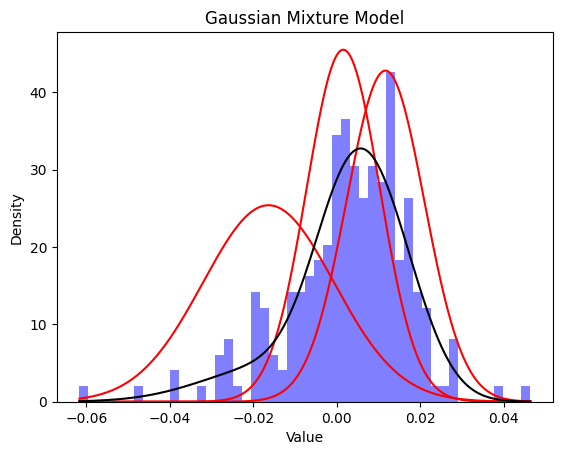

In [34]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.stats import norm

class CleanGMM:
    def __init__(self):
        daily_returns_sanitized = clean_data
        self.n_components = 3
        self.component_pdfs = [None] * self.n_components
        self.daily_returns_sanitized = np.array(daily_returns_sanitized).reshape(-1, 1)
        self.gmm = GaussianMixture(n_components=self.n_components)
        self.gmm.fit(self.daily_returns_sanitized)
        self.plot(self.gmm, self.n_components)
        
    def plot(self, gmm: GaussianMixture, n_components: int):
        plt.hist(self.daily_returns_sanitized, bins=50, density=True, alpha=0.5, color='blue')
        x = np.linspace(min(self.daily_returns_sanitized), max(self.daily_returns_sanitized), 1000)
        for i in range(n_components):
            self.component_pdfs[i] = norm(loc=gmm.means_[i], scale=math.sqrt(gmm.covariances_[i]))
            plt.plot(x, self.component_pdfs[i].pdf(x), color='red')
        plt.plot(x, np.exp(self.gmm.score_samples(np.array(x))), color='black')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title('Gaussian Mixture Model')
        plt.show()

    def call_pdf_creator(self, strike: float, spot: float):
        """
        Generates PDF to price call option given a KDE representing the returns over next time period
        """
        def pdf(x):
            return math.exp(self.gmm.score_samples(np.array([[x]]))[0]) * max(0, spot * math.exp(x) - strike)
        return pdf
    
    def put_pdf_creator(self, strike: float, spot: float):
        """
        Generates PDF to price put option given a KDE representing the returns over next time period
        """
        def pdf(x):
            return math.exp(self.gmm.score_samples(np.array([[x]]))[0]) * max(0, strike - spot * math.exp(x))
        return pdf

    def call_theo(self, strike: float, spot: float, show_plot: bool) -> float:
        """
        Integrates PDF to get call option theo
        """
        pdf = self.call_pdf_creator(strike=strike, spot=spot)
        result, error = quad(pdf, -1, 1)
        if error > 1e-3:
            print(f"WARNING (call): error on integration {error} > 1e-3")
        if show_plot:
            x_d = np.linspace(-0.25, 0.25, 1000)
            y_d = [pdf(x) for x in x_d]
            plt.plot(x_d, y_d, color='k', label='KDE')
            plt.title('Call Theo PDF')
            plt.show()
        return result
    
    def put_theo(self, strike: float, spot: float, show_plot: bool):
        """
        Integrates PDF to get pdf option theo
        """
        pdf = self.put_pdf_creator(strike=strike, spot=spot)
        result, error = quad(pdf, -1, 1)
        if error > 1e-3:
            print(f"WARNING (put): error on integration {error} > 1e-3")
        if show_plot:
            x_d = np.linspace(-0.25, 0.25, 1000)
            y_d = [pdf(x) for x in x_d]
            plt.plot(x_d, y_d, color='k', label='KDE')
            plt.title('Put Theo PDF')
            plt.show()
        return result
    
    def signal(self, strike: float, spot: float, bid: float, ask: float, right: Right, verbose: bool=False, show_plot: bool=False):
        """
        Run the model to determine if there's a signal.

        Returns:
        +1 for long
        0 for no signal
        -1 for short
        """
        if verbose: print(f"strike: {strike}, spot: {spot}")
        if right == Right.CALL:
            theo = self.call_theo(strike=strike, spot=spot, show_plot=show_plot)
            if verbose: print(f"theo (call): {theo}, bid: {bid}, ask: {ask}")
            return (int(theo > ask) - int(theo < bid), theo)
        else:
            theo = self.put_theo(strike=strike, spot=spot, show_plot=show_plot)
            if verbose: print(f"theo (put): {theo}, bid: {bid}, ask: {ask}")
            return (int(theo > ask) - int(theo < bid), theo)
        
svxy_model = CleanGMM()

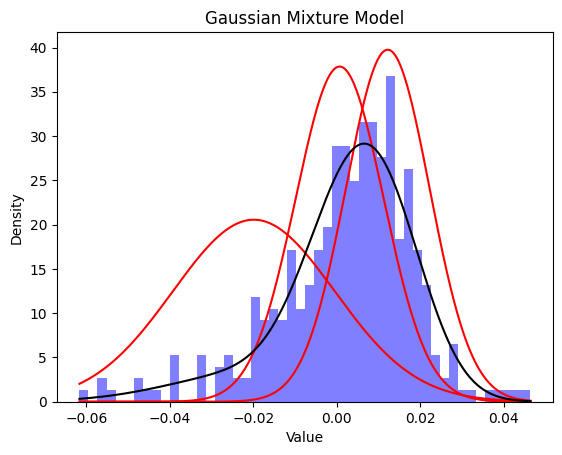

In [46]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.stats import norm

class GMM:
    def __init__(self, root: str, start_date: dt.date):
        price = pdr.get_data_yahoo([root], start_date, dt.date.today(), progress=False)['Adj Close']
        daily_returns = np.log(price/price.shift(1))
        daily_returns_sanitized = [x for x in daily_returns.values if x is not None and math.isfinite(x) and abs(x) < 1.5]
        self.n_components = 3
        self.component_pdfs = [None] * self.n_components
        self.daily_returns_sanitized = np.array(daily_returns_sanitized).reshape(-1, 1)
        self.gmm = GaussianMixture(n_components=self.n_components)
        self.gmm.fit(self.daily_returns_sanitized)
        self.plot(self.gmm, self.n_components)
        
    def plot(self, gmm: GaussianMixture, n_components: int):
        plt.hist(self.daily_returns_sanitized, bins=50, density=True, alpha=0.5, color='blue')
        x = np.linspace(min(self.daily_returns_sanitized), max(self.daily_returns_sanitized), 1000)
        for i in range(n_components):
            self.component_pdfs[i] = norm(loc=gmm.means_[i], scale=math.sqrt(gmm.covariances_[i]))
            plt.plot(x, self.component_pdfs[i].pdf(x), color='red')
        plt.plot(x, np.exp(self.gmm.score_samples(np.array(x))), color='black')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title('Gaussian Mixture Model')
        plt.show()

    def call_pdf_creator(self, strike: float, spot: float):
        """
        Generates PDF to price call option given a KDE representing the returns over next time period
        """
        def pdf(x):
            return math.exp(self.gmm.score_samples(np.array([[x]]))[0]) * max(0, spot * math.exp(x) - strike)
        return pdf
    
    def put_pdf_creator(self, strike: float, spot: float):
        """
        Generates PDF to price put option given a KDE representing the returns over next time period
        """
        def pdf(x):
            return math.exp(self.gmm.score_samples(np.array([[x]]))[0]) * max(0, strike - spot * math.exp(x))
        return pdf

    def call_theo(self, strike: float, spot: float, show_plot: bool) -> float:
        """
        Integrates PDF to get call option theo
        """
        pdf = self.call_pdf_creator(strike=strike, spot=spot)
        result, error = quad(pdf, -1, 1)
        if error > 1e-3:
            print(f"WARNING (call): error on integration {error} > 1e-3")
        if show_plot:
            x_d = np.linspace(-0.25, 0.25, 1000)
            y_d = [pdf(x) for x in x_d]
            plt.plot(x_d, y_d, color='k', label='KDE')
            plt.title('Call Theo PDF')
            plt.show()
        return result
    
    def put_theo(self, strike: float, spot: float, show_plot: bool):
        """
        Integrates PDF to get pdf option theo
        """
        pdf = self.put_pdf_creator(strike=strike, spot=spot)
        result, error = quad(pdf, -1, 1)
        if error > 1e-3:
            print(f"WARNING (put): error on integration {error} > 1e-3")
        if show_plot:
            x_d = np.linspace(-0.25, 0.25, 1000)
            y_d = [pdf(x) for x in x_d]
            plt.plot(x_d, y_d, color='k', label='KDE')
            plt.title('Put Theo PDF')
            plt.show()
        return result
    
    def signal(self, strike: float, spot: float, bid: float, ask: float, right: Right, verbose: bool=False, show_plot: bool=False):
        """
        Run the model to determine if there's a signal.

        Returns:
        +1 for long
        0 for no signal
        -1 for short
        """
        if verbose: print(f"strike: {strike}, spot: {spot}")
        if right == Right.CALL:
            theo = self.call_theo(strike=strike, spot=spot, show_plot=show_plot)
            if verbose: print(f"theo (call): {theo}, bid: {bid}, ask: {ask}")
            return (int(theo > ask) - int(theo < bid), theo)
        else:
            theo = self.put_theo(strike=strike, spot=spot, show_plot=show_plot)
            if verbose: print(f"theo (put): {theo}, bid: {bid}, ask: {ask}")
            return (int(theo > ask) - int(theo < bid), theo)

trash_model = GMM(root="SVXY", start_date=dt.date(2022, 10, 12))

In [13]:
stock = pdr.DataReader('AAPL', data_source='yahoo', start='2001-01-01', end='2023-01-12')
stock.earnings_dates

TypeError: download() got an unexpected keyword argument 'data_source'

In [35]:
class Engine:
    def __init__(self, root: str, start_date: dt.date):
        self.calls_long = 0
        self.calls_long_pnl = 0
        self.calls_short = 0
        self.calls_short_pnl = 0
        self.puts_long = 0
        self.puts_long_pnl = 0
        self.puts_short = 0
        self.puts_short_pnl = 0
        self.trades = []
        self.spot_price = pdr.get_data_yahoo([root], start_date, dt.date.today(), progress=False)['Adj Close']

    def pnl_option_to_expiry(self, entry: float, strike: float, exp: dt.date, right: Right, direction: int, theo: float, bid: float, ask: float):
        """
        Update backtest PnL with new option held-to-expiry trade
        """
        if right==right.CALL:
            if direction==1:
                self.calls_long += 1
                self.calls_long_pnl += max(self.spot_price[exp.strftime("%Y-%m-%d")] - strike, 0) - entry
                self.trades.append([right.value, direction, entry, strike, max(self.spot_price[exp.strftime("%Y-%m-%d")] - strike, 0) - entry, theo, bid, ask])
            else:
                self.calls_short += 1
                self.calls_short_pnl += entry - max(self.spot_price[exp.strftime("%Y-%m-%d")] - strike, 0)
                self.trades.append([right.value, direction, entry, strike, entry - max(self.spot_price[exp.strftime("%Y-%m-%d")] - strike, 0), theo, bid, ask])
        else:
            if direction==1:
                self.puts_long += 1
                self.puts_long_pnl += max(strike - self.spot_price[exp.strftime("%Y-%m-%d")], 0) - entry
                self.trades.append([right.value, direction, entry, strike, max(strike - self.spot_price[exp.strftime("%Y-%m-%d")], 0) - entry, theo, bid, ask])
            else:
                self.puts_short += 1
                self.puts_short_pnl += entry - max(strike - self.spot_price[exp.strftime("%Y-%m-%d")], 0)
                self.trades.append([right.value, direction, entry, strike, entry - max(strike - self.spot_price[exp.strftime("%Y-%m-%d")], 0), theo, bid, ask])

    def print_pnl(self):
        print(f"calls long: {self.calls_long}, calls long PnL: {self.calls_long_pnl}")
        print(f"calls short: {self.calls_short}, calls short PnL: {self.calls_short_pnl}")
        print(f"puts long: {self.puts_long}, puts long PnL: {self.puts_long_pnl}")
        print(f"puts short: {self.puts_short}, puts short PnL: {self.puts_short_pnl}")
    
    def get_trades(self):
        return pd.DataFrame(self.trades, columns=["Right", "Direction", "Entry", "Strike", "PnL", "Theo", "Bid", "Ask"])

In [44]:
# backtesting framework - SVIX and SVXY
flag = True
svix_expirations = client.get_expirations(root="SVIX")["response"][-280:-250]
svxy_expirations = client.get_expirations(root="SVXY")["response"][-280:-80]
print(svix_expirations, svxy_expirations)
#svix_model = Model("SVIX", dt.date(2000, 1, 1))
#svxy_model = Model("SVXY", dt.date(2000, 1, 1))
engine = Engine("SVXY", dt.date(2000, 1, 1))

svxy_start_dates = []
for exp in svxy_expirations: # last trade on previous day (1 day before expiration)
    # get previous day
    exp_datetime = dt.datetime.strptime(str(exp), "%Y%m%d")
    start_date_datetime = exp_datetime - timedelta(days=1)
    start_date = int(start_date_datetime.strftime("%Y%m%d"))
    svxy_start_dates.append(start_date)

for exp, start_date in zip(svxy_expirations, svxy_start_dates):
    strikes = client.get_strikes(root="SVXY", exp=exp)["response"]

    start_date_datetime = dt.datetime.strptime(str(start_date), "%Y%m%d")
    start_year = start_date_datetime.year
    start_month = start_date_datetime.month
    start_day = start_date_datetime.day

    exp_datetime = dt.datetime.strptime(str(exp), "%Y%m%d")
    exp_year = exp_datetime.year
    exp_month = exp_datetime.month
    exp_day = exp_datetime.day

    svxy = pdr.get_data_yahoo(["SVXY"], dt.date(start_year, start_month, start_day), dt.date(exp_year, exp_month, exp_day), progress=False)['Adj Close']
    vix = pdr.get_data_yahoo(["^VIX"], dt.date(start_year, start_month, start_day), dt.date(exp_year, exp_month, exp_day), progress=False)['Adj Close']
    if svxy.size == 0 or vix.size == 0:
        continue

    spot_price = svxy.iloc[0]
    spot_vix = vix.iloc[0]
    index = bisect.bisect_left(strikes, spot_price * 1000)
    try:
        strike_price = strikes[index]
    except:
        strike_price = strikes[index - 1]
    K = strike_price / 1000

    try:
        chain_call = wrapper_client.get_chain_over_time(root="SVXY", exp=exp, strike=strike_price, right=Right.CALL, ivl=3600000, start_date=start_date, end_date=start_date)
        chain_put = wrapper_client.get_chain_over_time(root="SVXY", exp=exp, strike=strike_price, right=Right.PUT, ivl=3600000, start_date=start_date, end_date=start_date)
    except:
        continue
    
    last_call = chain_call.iloc[-1]
    last_put = chain_put.iloc[-1]

    call_signal, call_theo = svxy_model.signal(strike=K, spot=spot_price, bid=last_call["bid"], ask=last_call["ask"], right=Right.CALL)
    put_signal, put_theo = svxy_model.signal(strike=K, spot=spot_price, bid=last_put["bid"], ask=last_put["ask"], right=Right.PUT)
    call_mid = (last_call["ask"] + last_call["bid"]) / 2
    put_mid = (last_put["ask"] + last_put["bid"]) / 2
    if call_signal == 1:
        engine.pnl_option_to_expiry(entry=last_call["ask"], strike=K, exp=exp_datetime, right=Right.CALL, direction=1, theo=call_theo, bid=last_call["bid"], ask=last_call["ask"])
    elif call_signal == -1:
        engine.pnl_option_to_expiry(entry=last_call["bid"], strike=K, exp=exp_datetime, right=Right.CALL, direction=-1, theo=call_theo, bid=last_call["bid"], ask=last_call["ask"])
    if put_signal == 1:
        engine.pnl_option_to_expiry(entry=last_put["ask"], strike=K, exp=exp_datetime, right=Right.PUT, direction=1, theo=put_theo, bid=last_put["bid"], ask=last_put["ask"])
    elif put_signal == -1:
        engine.pnl_option_to_expiry(entry=last_put["bid"], strike=K, exp=exp_datetime, right=Right.PUT, direction=-1, theo=put_theo, bid=last_put["bid"], ask=last_put["ask"])

engine.print_pnl()
engine.get_trades()


[] [20190125, 20190201, 20190208, 20190215, 20190222, 20190301, 20190308, 20190315, 20190322, 20190329, 20190405, 20190412, 20190418, 20190426, 20190503, 20190510, 20190517, 20190524, 20190531, 20190607, 20190614, 20190621, 20190628, 20190705, 20190712, 20190719, 20190726, 20190802, 20190809, 20190816, 20190823, 20190830, 20190906, 20190913, 20190920, 20190927, 20191004, 20191011, 20191018, 20191025, 20191101, 20191108, 20191115, 20191122, 20191129, 20191206, 20191213, 20191220, 20191227, 20200103, 20200110, 20200117, 20200124, 20200131, 20200207, 20200214, 20200221, 20200228, 20200306, 20200313, 20200320, 20200327, 20200403, 20200409, 20200417, 20200424, 20200501, 20200508, 20200515, 20200522, 20200529, 20200605, 20200612, 20200619, 20200626, 20200702, 20200710, 20200717, 20200724, 20200731, 20200807, 20200814, 20200821, 20200828, 20200904, 20200911, 20200918, 20200925, 20201002, 20201009, 20201016, 20201023, 20201030, 20201106, 20201113, 20201120, 20201127, 20201204, 20201211, 202012


1 Failed download:
['SVXY']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-07-04 -> 2019-07-05)')

1 Failed download:
['^VIX']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-07-04 -> 2019-07-05)')

1 Failed download:
['SVXY']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-11-28 -> 2019-11-29)')

1 Failed download:
['^VIX']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-11-28 -> 2019-11-29)')


Request failed with status code 472
No data for the specified timeframe & contract.



1 Failed download:
['SVXY']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-11-26 -> 2020-11-27)')

1 Failed download:
['^VIX']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-11-26 -> 2020-11-27)')

1 Failed download:
['SVXY']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-11-25 -> 2021-11-26)')

1 Failed download:
['^VIX']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-11-25 -> 2021-11-26)')


calls long: 35, calls long PnL: 2.140004882812498
calls short: 92, calls short PnL: -0.4599945068359368
puts long: 3, puts long PnL: -1.120000762939453
puts short: 152, puts short PnL: 11.439996109008792


,Right,Direction,Entry,Strike,PnL,Theo,Bid,Ask
0,P,-1,0.39,46.5,0.390000,0.339241,0.39,0.95
1,C,1,0.14,48.5,-0.140000,0.180093,0.09,0.14
2,P,-1,0.39,48.5,0.320000,0.352196,0.39,0.94
3,C,1,0.19,49.0,-0.180002,0.211107,0.07,0.19
4,P,-1,0.55,49.0,0.550000,0.321606,0.55,0.97
5,C,1,0.22,51.0,0.510000,0.244772,0.07,0.22
6,C,-1,0.15,51.5,-0.530000,0.139127,0.15,0.23
7,P,-1,0.31,53.0,0.310000,0.308039,0.31,0.60
8,P,-1,0.58,52.0,0.580000,0.454593,0.58,2.36
9,P,-1,0.33,53.0,0.330000,0.254549,0.33,0.54


In [ ]:
"""
Base KDE (Scott's Rule) stats
calls long: 135, calls long PnL: -5.760001220703127
calls short: 12, calls short PnL: 4.309998321533203
puts long: 73, puts long PnL: -14.620008850097655
puts short: 17, puts short PnL: -0.11999900817871012
"""

"""
VIX parametrized KDE (Scott's Rule) stats
calls long: 154, calls long PnL: -4.389995117187501
calls short: 6, calls short PnL: 2.51999755859375
puts long: 105, puts long PnL: -26.77999534606934
puts short: 8, puts short PnL: 1.1500010681152344
"""

"""
calls long: 117, calls long PnL: -7.599999084472657
calls short: 23, calls short PnL: 0.6600027465820307
puts long: 59, puts long PnL: -12.28001113891602
puts short: 21, puts short PnL: -0.11999946594238198

calls long: 117, calls long PnL: 1.2750009155273427
calls short: 23, calls short PnL: 5.430002746582031
puts long: 59, puts long PnL: -5.980011138916015
puts short: 21, puts short PnL: 4.110000534057618
"""

In [26]:
dates = wrapper_client.get_dates_in_range(root="AAPL", exp=20220930, start_date=20220910, end_date=20220928)[2]
strikes = [135000, 140000, 145000] #client.get_strikes(root="AAPL", exp=20220930)["response"]
for K in strikes:
    # print(wrapper_client.get_chain_over_time(root="AAPL", exp=20220930, strike=K, right=Right.CALL, dates=dates))
    print(wrapper_client.get_chain_over_time(root="AAPL", exp=20220930, strike=K, right=Right.CALL, ivl=3600000, start_date=20220910, end_date=20220928))

        date  ms_of_day    bid    ask
0   20220912   36000000  26.90  27.00
1   20220912   39600000  26.70  26.80
2   20220912   43200000  27.20  27.30
3   20220912   46800000  28.40  28.50
4   20220912   50400000  29.45  29.50
..       ...        ...    ...    ...
86  20220928   43200000  12.50  12.55
87  20220928   46800000  12.85  12.95
88  20220928   50400000  12.50  12.60
89  20220928   54000000  13.90  13.95
90  20220928   57600000  14.75  15.05

[91 rows x 4 columns]
        date  ms_of_day    bid    ask
0   20220912   36000000  22.05  22.15
1   20220912   39600000  21.80  21.90
2   20220912   43200000  22.30  22.40
3   20220912   46800000  23.50  23.60
4   20220912   50400000  24.55  24.60
..       ...        ...    ...    ...
86  20220928   43200000   7.75   7.85
87  20220928   46800000   8.10   8.15
88  20220928   50400000   7.75   7.85
89  20220928   54000000   9.05   9.15
90  20220928   57600000   9.95  10.20

[91 rows x 4 columns]
        date  ms_of_day    bid    ask
0   

In [27]:
print(wrapper_client.get_chain_over_time(root="SVXY", exp=20230317, strike=55000, right=Right.CALL, ivl=3600000, start_date=20230117, end_date=20230317))
print(wrapper_client.get_chain_over_time(root="SVXY", exp=20230317, strike=55000, right=Right.PUT, ivl=3600000, start_date=20230117, end_date=20230317))
print(client.get_expirations(root="SVXY"))

,date,ms_of_day,bid,ask
0,20230117,36000000,9.00,9.70
1,20230117,39600000,8.50,9.50
2,20230117,43200000,9.20,9.80
3,20230117,46800000,9.40,10.20
4,20230117,50400000,9.50,9.90
...,...,...,...,...
296,20230317,43200000,3.10,3.40
297,20230317,46800000,3.10,3.30
298,20230317,50400000,3.10,3.50
299,20230317,54000000,2.60,2.85


In [37]:
eod = client.get_eod_prices(root=root, start_date=20230301, end_date=20230406, exp=20230406, strike=150000, right=Right.CALL, security_type=Security.OPTION)
eod

http://127.0.0.1:25510/hist/option/eod?root=AAPL&start_date=20230301&end_date=20230406&strike=150000&exp=20230406&right=C


{'header': {'id': 35,
  'latency_ms': 466,
  'error_type': 'null',
  'error_msg': 'null',
  'next_page': 'null',
  'format': ['open', 'high', 'low', 'close', 'volume', 'count', 'date']},
 'response': [[3.95, 3.95, 3.13, 3.2, 319, 55, 20230301],
  [2.8, 3.5, 2.59, 3.3, 484, 67, 20230302],
  [4.05, 5.6, 3.75, 5.6, 1079, 217, 20230303],
  [7.33, 9.05, 7.0, 7.3, 752, 135, 20230306],
  [7.22, 7.35, 5.6, 5.9, 294, 65, 20230307],
  [6.6, 6.95, 6.2, 6.5, 274, 53, 20230308],
  [6.8, 7.55, 5.35, 5.4, 197, 52, 20230309],
  [5.05, 5.4, 4.01, 4.26, 430, 135, 20230310],
  [4.4, 6.7, 4.16, 5.3, 463, 136, 20230313],
  [5.86, 6.5, 4.88, 5.76, 1547, 160, 20230314],
  [5.55, 6.7, 4.98, 6.32, 301, 73, 20230315],
  [6.2, 8.5, 6.0, 8.15, 176, 54, 20230316],
  [7.75, 8.71, 7.4, 7.7, 79, 37, 20230317],
  [7.7, 9.45, 7.55, 9.23, 62, 40, 20230320],
  [9.71, 10.48, 8.56, 10.43, 88, 36, 20230321],
  [10.85, 12.44, 9.73, 9.73, 145, 58, 20230322],
  [10.3, 12.1, 9.56, 10.37, 83, 37, 20230323],
  [10.07, 10.9, 9.4, 

In [38]:
quotes = client.get_hist_quotes(root=root, start_date=20230331, end_date=20230331, exp=20230406, strike=150000, right=Right.CALL, ivl=60000)
quotes

{'header': {'id': 36,
  'latency_ms': 48,
  'error_type': 'null',
  'error_msg': 'null',
  'next_page': 'null',
  'format': ['ms_of_day',
   'bid_size',
   'bid_condition',
   'bid',
   'bid_exchange',
   'ask_size',
   'ask_condition',
   'ask',
   'ask_exchange',
   'date']},
 'response': [[34200000, 0, 1, 0.0, 50, 0, 1, 0.0, 50, 20230331],
  [34260000, 90, 11, 12.5, 50, 90, 11, 12.9, 50, 20230331],
  [34320000, 90, 11, 12.5, 50, 90, 11, 12.9, 50, 20230331],
  [34380000, 90, 11, 12.5, 50, 90, 11, 12.8, 50, 20230331],
  [34440000, 90, 11, 12.8, 50, 90, 11, 13.05, 50, 20230331],
  [34500000, 90, 11, 13.05, 50, 90, 11, 13.35, 50, 20230331],
  [34560000, 91, 11, 12.9, 50, 90, 11, 13.15, 50, 20230331],
  [34620000, 90, 11, 12.95, 50, 90, 11, 13.2, 50, 20230331],
  [34680000, 90, 11, 12.9, 50, 92, 11, 13.2, 50, 20230331],
  [34740000, 39, 11, 12.95, 50, 93, 11, 13.15, 50, 20230331],
  [34800000, 39, 11, 12.8, 50, 90, 11, 13.0, 50, 20230331],
  [34860000, 90, 11, 12.95, 50, 39, 11, 13.15, 5

In [39]:
ohlc = client.get_ohlc(root=root, start_date=20230331, end_date=20230331, exp=20230406, strike=150000, right=Right.CALL, ivl=900000)
ohlc

{'header': {'id': 37,
  'latency_ms': 29,
  'error_type': 'null',
  'error_msg': 'null',
  'next_page': 'null',
  'format': ['ms_of_day',
   'open',
   'high',
   'low',
   'close',
   'volume',
   'count',
   'date']},
 'response': [[34200000, 0.0, 0.0, 0.0, 0.0, 0, 0, 20230331],
  [35100000, 12.77, 12.77, 12.64, 12.64, 2, 2, 20230331],
  [36000000, 12.78, 12.98, 12.78, 12.85, 4, 4, 20230331],
  [36900000, 12.85, 12.85, 12.5, 12.5, 9, 6, 20230331],
  [37800000, 12.73, 12.76, 12.73, 12.73, 22, 4, 20230331],
  [38700000, 12.95, 13.15, 12.95, 13.08, 104, 3, 20230331],
  [39600000, 13.13, 13.13, 12.95, 12.95, 3, 3, 20230331],
  [40500000, 0.0, 0.0, 0.0, 0.0, 0, 0, 20230331],
  [41400000, 13.05, 13.05, 13.05, 13.05, 10, 1, 20230331],
  [42300000, 0.0, 0.0, 0.0, 0.0, 0, 0, 20230331],
  [43200000, 13.35, 13.35, 13.35, 13.35, 11, 2, 20230331],
  [44100000, 13.41, 13.5, 13.41, 13.49, 9, 4, 20230331],
  [45000000, 13.6, 14.03, 13.6, 14.03, 27, 8, 20230331],
  [45900000, 14.07, 14.09, 13.8, 14.0

In [40]:
oi = client.get_hist_oi(root=root, start_date=20230301, end_date=20230401, exp=20230406, strike=150000, right=Right.CALL, ivl=900000)
oi

{'header': {'id': 38,
  'latency_ms': 964,
  'error_type': 'null',
  'error_msg': 'null',
  'next_page': 'null',
  'format': ['open_interest', 'date']},
 'response': [[207, 20230301],
  [325, 20230302],
  [716, 20230303],
  [1426, 20230306],
  [1406, 20230307],
  [1474, 20230308],
  [1549, 20230309],
  [1546, 20230310],
  [1640, 20230313],
  [1646, 20230314],
  [1834, 20230315],
  [1835, 20230316],
  [1779, 20230317],
  [1790, 20230320],
  [1781, 20230321],
  [1789, 20230322],
  [1791, 20230323],
  [1791, 20230324],
  [1785, 20230327],
  [1752, 20230328],
  [1784, 20230329],
  [1868, 20230330],
  [1886, 20230331]]}

In [46]:
trades = client.get_hist_trades(root=root, start_date=20230301, end_date=20230331, exp=20230406, strike=150000, right=Right.CALL)
trades

{'header': {'id': 44,
  'latency_ms': 0,
  'error_type': 'DISCONNECTED',
  'error_msg': 'Connection lost to Theta Data MDDS.',
  'next_page': 'null',
  'format': None},
 'response': [0]}

In [42]:
quotes = client.get_hist_quotes(root=root, start_date=20230331, end_date=20230331, exp=20230406, strike=150000, right=Right.CALL)
quotes

{'header': {'id': 40,
  'latency_ms': 64,
  'error_type': 'null',
  'error_msg': 'null',
  'next_page': 'null',
  'format': ['ms_of_day',
   'bid_size',
   'bid_condition',
   'bid',
   'bid_exchange',
   'ask_size',
   'ask_condition',
   'ask',
   'ask_exchange',
   'date']},
 'response': [[28800211, 0, 60, 0.0, 50, 0, 60, 0.0, 50, 20230331],
  [28800257, 0, 42, 0.0, 50, 0, 42, 0.0, 50, 20230331],
  [28800326, 0, 65, 0.0, 50, 0, 65, 0.0, 50, 20230331],
  [28801788, 0, 5, 0.0, 50, 0, 5, 0.0, 50, 20230331],
  [30600163, 0, 65, 0.0, 50, 0, 65, 0.0, 50, 20230331],
  [30600195, 0, 42, 0.0, 50, 0, 42, 0.0, 50, 20230331],
  [30600196, 0, 60, 0.0, 50, 0, 60, 0.0, 50, 20230331],
  [30601668, 0, 5, 0.0, 50, 0, 5, 0.0, 50, 20230331],
  [32400090, 0, 60, 0.0, 50, 0, 60, 0.0, 50, 20230331],
  [32400126, 0, 42, 0.0, 50, 0, 42, 0.0, 50, 20230331],
  [32400253, 0, 5, 0.0, 50, 0, 5, 0.0, 50, 20230331],
  [32400340, 0, 65, 0.0, 50, 0, 65, 0.0, 50, 20230331],
  [33900204, 0, 31, 0.0, 50, 0, 31, 0.0, 50

In [44]:
iv = client.get_hist_iv(root=root, start_date=20230301, end_date=20230331, exp=20230406, strike=150000, right=Right.CALL, ivl=3600000)
iv

{'header': {'id': 42,
  'latency_ms': 21011,
  'error_type': 'null',
  'error_msg': 'null',
  'next_page': 'null',
  'format': ['ms_of_day',
   'bid',
   'bid_implied_vol',
   'midpoint',
   'implied_vol',
   'ask',
   'ask_implied_vol',
   'underlying_price',
   'date']},
 'response': [[36000000,
   3.5,
   0.2478,
   3.9,
   0.2701,
   4.3,
   0.292,
   146.92,
   20230301],
  [39600000, 3.65, 0.2671, 3.7, 0.2699, 3.75, 0.2725, 146.47, 20230301],
  [43200000, 3.65, 0.2672, 3.67, 0.2687, 3.7, 0.2703, 146.45, 20230301],
  [46800000, 3.6, 0.2664, 3.62, 0.2674, 3.65, 0.2691, 146.38, 20230301],
  [50400000, 3.4, 0.267, 3.42, 0.2682, 3.45, 0.27, 145.87, 20230301],
  [54000000, 3.25, 0.2677, 3.27, 0.2693, 3.3, 0.2702, 145.48, 20230301],
  [57600000, 3.15, 0.2653, 3.35, 0.2768, 3.55, 0.2882, 145.32, 20230301],
  [36000000, 2.74, 0.2669, 2.76, 0.2681, 2.78, 0.2693, 144.34, 20230302],
  [39600000, 2.75, 0.2643, 2.76, 0.2649, 2.78, 0.2661, 144.48, 20230302],
  [43200000, 2.69, 0.2635, 2.71, 0.2

In [ ]:
eod_greeks = client.get_eod_greeks(root=root, exp=20230406, start_date=20230329, end_date=20230331)
eod_greeks